In [1]:
import xarray as xr
# import matplotlib.pyplot as plt
import datetime
from glob import glob
import dask, dask.distributed
import dask_jobqueue
import matplotlib.pyplot as plt
import datetime
import numpy as np
# import parcels
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import cmocean
from xhistogram.xarray import histogram as xhist
import seawater as gsw
import matplotlib.colors as mcolors
import datetime as dt 

In [2]:
cluster = dask_jobqueue.SLURMCluster(

    # Dask worker size
    cores=4, memory='16GB',
    processes=1, # Dask workers per job
    
    # SLURM job script things
    queue='base', walltime='04:00:00',
    
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',  # for spilling tmp data to disk
    log_directory='slurm/' 
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=15) #15
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.18.4.23:8787/status,
Dashboard: http://172.18.4.23:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.18.4.23:42527,Workers: 0
Dashboard: http://172.18.4.23:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
def filter_beached_particles(ds,dim=None):
    """
    Filter particles in the dataset based on salinity.

    Parameters:
    ds (xarray.Dataset): The dataset containing salinity data.

    Returns:
    xarray.Dataset: A filtered dataset including only particles that have not reached zero salinity.
    """
    # Identify particles that reach zero salinity
    particles_reach_zero_salinity = (ds.salt == 0).any(dim)

    # Identify particles that have not reached zero salinity (beached)
    particles_beached = ~particles_reach_zero_salinity

    # Filter the dataset to include only particles that have not reached zero salinity
    ds_particles_reach_zero_salinity_beached = ds.where(particles_beached.compute(), drop=True)

    return ds_particles_reach_zero_salinity_beached

def compute_density(ds):
    ds_density = xr.apply_ufunc(gsw.eos80.pden,ds.salt,ds.temp,0,dask='parallelized',output_dtypes=[np.float64]) - 1000
    ds_add_dens = ds.assign(sigma0=ds_density)
    return ds_add_dens

def filter_particles_by_density(ds, density_threshold, dim=None):
    """
    Filter particles in the dataset based on a density threshold.

    Parameters:
    ds (xarray.Dataset): The input dataset containing particle density information.
    density_threshold (float): The density threshold for filtering particles (default is 28 kg/m³).

    Returns:
    xarray.Dataset: A dataset containing particles that exceed the specified density threshold.
    """
    # Identify particles with density less than the threshold
    particles_less_than_threshold = (ds.sigma0 < density_threshold).any(dim)
    
    # Identify particles that reach or exceed the threshold
    particles_that_reach_threshold = ~particles_less_than_threshold
    
    # Filter the dataset to include only particles that exceed the threshold
    ds_particles_greater_than_threshold = ds.where(particles_that_reach_threshold.compute(), drop=True)
    
    return ds_particles_greater_than_threshold



In [65]:
ds = xr.open_dataset('data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')
# ds = filter_beached_particles(ds,'obs')
ds = compute_density(ds)

In [239]:
p=ds 
p['start_time'] = p.isel(obs=0).time

# this is added!
yyyymm = p.start_time.dt.strftime('%Y%m').astype(int)
p['yyyymm'] = yyyymm
p=p.set_coords('start_time')
p=p.set_xindex('start_time')

In [238]:
p.yyyymm

<xarray.DataArray 'yyyymm' (trajectory: 497743)>
dask.array<astype, shape=(497743,), dtype=int64, chunksize=(782,), chunktype=numpy.ndarray>
Coordinates:
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
  * start_time  (trajectory) datetime64[ns] 2003-01-01 ... 2020-05-31T00:00:01

In [240]:
traj_ind_sorted_by_depth_per_release = np.argsort(p.isel(obs=0,trajectory=slice(0,391)).z.values) # 391 is the # of particles stored per release 

# p = p.isel(trajectory=traj_ind_sorted_by_depth_per_release)
# first release sorted by depth 

In [181]:
#traj_ind_sorted_by_depth_per_release

In [30]:
# depth
# p.isel(obs=0,trajectory=slice(0,391)).z.values[traj_ind_sorted_by_depth_per_release]

In [66]:
## THIS WAS ORIGINAL JUST TESTING ONE DEPTH BASICALLY 
#avail_traj = sorted(list(set(p.trajectory.values).intersection(set(np.arange(14,ds.trajectory.max(), 1000)))))
#avail_traj = np.arange(14, len(ds.trajectory), 391)

avail_traj = [traj_ind_sorted_by_depth_per_release][:10][0] ## np.repeat and then add 391 to each repetition, first 10 depths for example  

In [241]:
# 700 - 800 m depth

# p.isel(obs=0,trajectory=slice(0,391)).z.values[traj_ind_sorted_by_depth_per_release][60:160]

In [242]:
[traj_ind_sorted_by_depth_per_release][0][150:375]

array([192,   6, 347, 226, 310,  22, 319, 277, 175,  94, 376,  84, 382,
       367,  48, 236, 381, 386, 106, 348,  74,  19, 103, 299, 166, 238,
        15, 136,  55, 302, 275,  80, 369,  66, 115, 220,  99, 195,  45,
       279, 202, 346, 127, 178,  16, 110, 102, 196, 389, 384, 170, 278,
       344,  68, 194, 286, 364, 109, 374, 341, 317, 188, 159,  47, 293,
       117, 239, 123, 114, 268, 287, 169, 332,   9, 241, 198, 209,  60,
       378, 253,  18,  42, 248, 251, 350, 199, 373, 343, 172, 377, 322,
        11,   5,  52, 134,  50,  95, 191, 200,  69, 339,  83, 224, 281,
       105, 284, 204, 190, 179, 225, 270, 340, 163, 233,  54, 276, 182,
       213, 290,  17, 365,  64, 180,  49, 189,  25, 240, 137, 342, 215,
       118, 351, 138, 167,  10, 222, 124, 305,  43, 249,  97,  34, 366,
       246, 326, 158,  71, 186, 122, 228, 320, 355, 283, 132, 162, 295,
       263, 174, 201,  86,   0, 235,  38, 121,  93, 361, 184, 312, 330,
        46,  85, 165, 325, 324, 252, 203, 307, 353,  58, 274, 33

In [ ]:
# 700 - 800m 
# p.isel(obs=0,trajectory=slice(0,391)).z.values[traj_ind_sorted_by_depth_per_release][60:160]

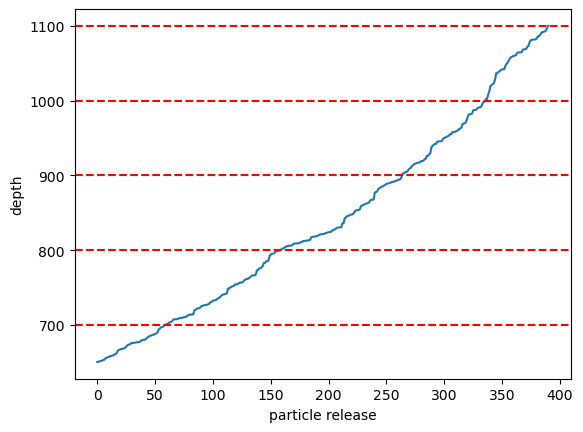

In [243]:
plt.plot(p.isel(obs=0,trajectory=slice(0,391)).z.values[traj_ind_sorted_by_depth_per_release])
plt.xlabel('particle release')
plt.ylabel('depth')
plt.axhline(y=700, color='r', linestyle='--')
plt.axhline(y=800, color='r', linestyle='--')
plt.axhline(y=900, color='r', linestyle='--')
plt.axhline(y=1000, color='r', linestyle='--')
plt.axhline(y=1100, color='r', linestyle='--');

In [97]:
#p.isel(trajectory=avail_traj)

In [70]:
# n_repeats = 5

# # Create the repeated array
# repeated_array = np.tile(array, n_repeats)

# # Create an array of increments
# increments = np.arange(n_repeats) * 2  # This will create [0, 2, 4] for 3 repeats

# # Add the increments to the repeated array
# result_array = repeated_array + increments[:, np.newaxis]

# # Flatten the result to get a 1D array
# result_array = result_array.flatten()

In [244]:

# Original array

avail_traj = [traj_ind_sorted_by_depth_per_release][0]#[70:160] # GO OVER ALL DEPTHS
original_array = avail_traj #np.array([1, 2, 3, 4])

# Number of repetitions
n_repeats = int(ds.trajectory.size/391) #391*2

# Create an array to hold the result
result_array = np.zeros(n_repeats * len(original_array), dtype=int)

# Fill the result array with the incremented values
for i in range(n_repeats):
    result_array[i * len(original_array):(i + 1) * len(original_array)] = original_array + (i * 391)

print(result_array)

avail_traj_extended = result_array

[    13    321     28 ... 497617 497453 497516]


In [85]:
#original_array[:391]
ds.trajectory.size/391

1273.0

In [73]:
#result_array[391:391*2]
#avail_traj[:391]

In [74]:
#avail_traj_extended[391*10:391*11]

In [245]:
#np.unique(p.isel(trajectory=avail_traj[0]).isel(obs=0).z.compute(), return_counts=True)

In [9]:
# assert len(np.unique(p.isel(trajectory=avail_traj).isel(obs=0).z.compute())) == 1

In [8]:
# _, c = np.unique(p.isel(trajectory=avail_traj).start_time, return_counts=True)
# assert np.all(c == 1), "Several trajectories per release time, that cannot be true"

In [134]:
p.isel(trajectory=avail_traj_extended).start_time.dt.year

<xarray.DataArray 'year' (trajectory: 114570)>
array([2003, 2003, 2003, ..., 2020, 2020, 2020])
Coordinates:
  * trajectory  (trajectory) int64 951 650 710 333 ... 3518451 3518172 3517962
  * start_time  (trajectory) datetime64[ns] 2003-01-01 ... 2020-05-31T00:00:01
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

In [75]:
# plt.pcolormesh(p.obs, p.isel(trajectory=avail_traj).trajectory, p.temp.isel(trajectory=avail_traj))
#p.isel(trajectory=sorted(avail_traj_extended)).temp.plot(x='obs', y='start_time', cmap='RdBu_r', vmin=-10,vmax=10)

In [141]:
p.isel(trajectory=sorted(avail_traj)).temp.start_time

<xarray.DataArray 'start_time' (trajectory: 391)>
array(['2003-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', ..., '2003-01-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * trajectory  (trajectory) int64 1 8 9 14 17 21 24 ... 984 992 993 995 998 999
  * start_time  (trajectory) datetime64[ns] 2003-01-01 2003-01-01 ... 2003-01-01
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

In [77]:
#p.temp.isel(trajectory=avail_traj, obs=slice(0,7500)).groupby('start_time.year').mean().T.plot()

In [143]:
avail_traj_extended

array([    13,    321,     28, ..., 497617, 497453, 497516])

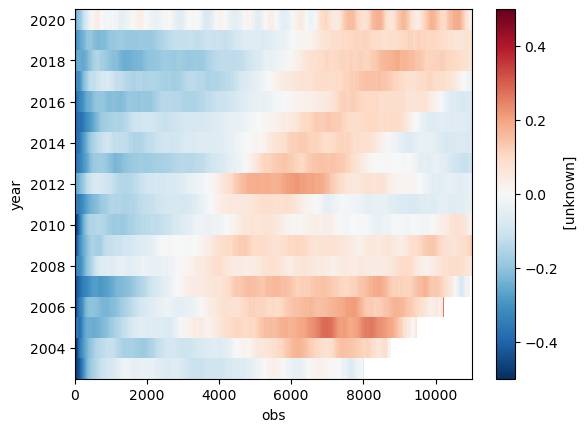

In [246]:
#avail_traj = [traj_ind_sorted_by_depth_per_release][:10]
#sorted(avail_traj)

p.temp.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).groupby('start_time.year').mean().plot()

In [247]:
# #sorted(avail_traj)

# p.temp.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).groupby('start_time.year').mean().plot()

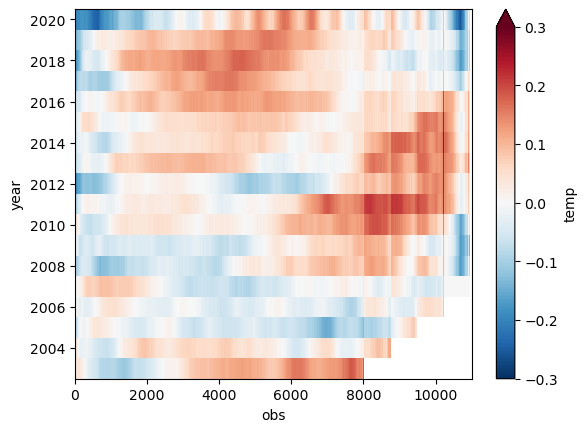

In [248]:
#p.resample(start_time='M').mean()
reference =  p.temp.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).groupby('start_time.year').mean().sel(year=slice(2003,2007)).mean('year') 
p_temp_grouped = p.temp.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).groupby('start_time.year')
(reference - p_temp_grouped.mean()).T.plot(vmin=-.3,vmax=.3,cmap='RdBu_r')

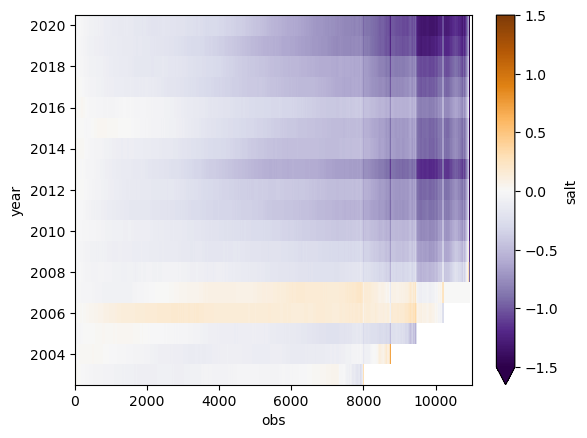

In [150]:
reference =  p.salt.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).groupby('start_time.year').mean().sel(year=slice(2003,2007)).mean('year') 
p_temp_grouped = p.salt.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).groupby('start_time.year')
(reference - p_temp_grouped.mean()).T.plot(cmap='PuOr_r',vmin=-1.5,vmax=1.5)

In [217]:
p.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).start_time

<xarray.DataArray 'start_time' (trajectory: 497743)>
array(['2003-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', ..., '2020-05-31T00:00:01.000000000',
       '2020-05-31T00:00:01.000000000', '2020-05-31T00:00:01.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
  * start_time  (trajectory) datetime64[ns] 2003-01-01 ... 2020-05-31T00:00:01
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

In [219]:
p.isel(trajectory=sorted(avail_traj_extended)).start_time.dt.strftime('%Y%m').astype(int)

<xarray.DataArray 'strftime' (trajectory: 497743)>
array([200301, 200301, 200301, ..., 202005, 202005, 202005])
Coordinates:
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
  * start_time  (trajectory) datetime64[ns] 2003-01-01 ... 2020-05-31T00:00:01

In [220]:
p.start_time.dt.strftime('%Y%m').astype(int).isel(trajectory=sorted(avail_traj_extended))

<xarray.DataArray 'strftime' (trajectory: 497743)>
array([200301, 200301, 200301, ..., 202005, 202005, 202005])
Coordinates:
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
  * start_time  (trajectory) datetime64[ns] 2003-01-01 ... 2020-05-31T00:00:01

In [221]:
#yyyymm = p.isel(trajectory=sorted(avail_traj_extended)).start_time.dt.strftime('%Y%m').astype(int)


In [267]:
p.yyyymm.isel(trajectory=sorted(avail_traj_extended))

<xarray.DataArray 'yyyymm' (trajectory: 497743)>
dask.array<astype, shape=(497743,), dtype=int64, chunksize=(782,), chunktype=numpy.ndarray>
Coordinates:
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
  * start_time  (trajectory) datetime64[ns] 2003-01-01 ... 2020-05-31T00:00:01

In [268]:
p.temp.isel(trajectory=sorted(avail_traj_extended))

<xarray.DataArray 'temp' (trajectory: 497743, obs: 20075)>
dask.array<open_dataset-temp, shape=(497743, 20075), dtype=float32, chunksize=(1564, 20075), chunktype=numpy.ndarray>
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 ... 20069 20070 20071 20072 20073 20074
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
  * start_time  (trajectory) datetime64[ns] 2003-01-01 ... 2020-05-31T00:00:01
Attributes:
    long_name:      
    standard_name:  temp
    units:          unknown

200301
200302
200303
200304
200305
200306
200307
200308
200309
200310
200311


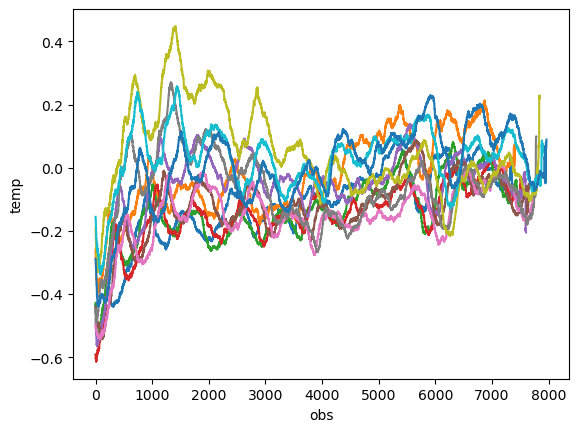

In [288]:
for i, (n, grp_ds) in enumerate(p[['temp','yyyymm']].isel(trajectory=sorted(avail_traj_extended)).groupby('yyyymm')):
    if i > 10: break
    print(n)
    grp_ds.temp.mean(dim='trajectory').plot()

In [290]:
testing = p[['temp','yyyymm']].isel(trajectory=sorted(avail_traj_extended)).groupby('yyyymm').mean(dim='trajectory').temp.compute()

In [301]:
testing.shape

(209, 20075)

In [303]:
testing.yyyymm

<xarray.DataArray 'yyyymm' (yyyymm: 209)>
array([200301, 200302, 200303, ..., 202003, 202004, 202005])
Coordinates:
  * yyyymm   (yyyymm) int64 200301 200302 200303 200304 ... 202003 202004 202005

TypeError: Dimensions of C (209, 11000) should be one smaller than X(209) and Y(11000) while using shading='flat' see help(pcolormesh)

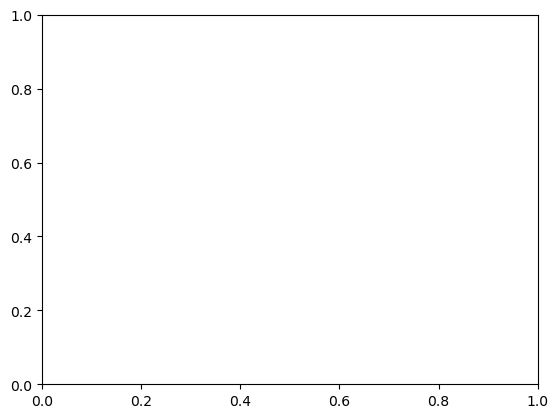

In [306]:
plt.pcolormesh(testing.yyyymm, testing.isel(obs=slice(0,11_000)).obs,testing.isel(obs=slice(0,11_000)))

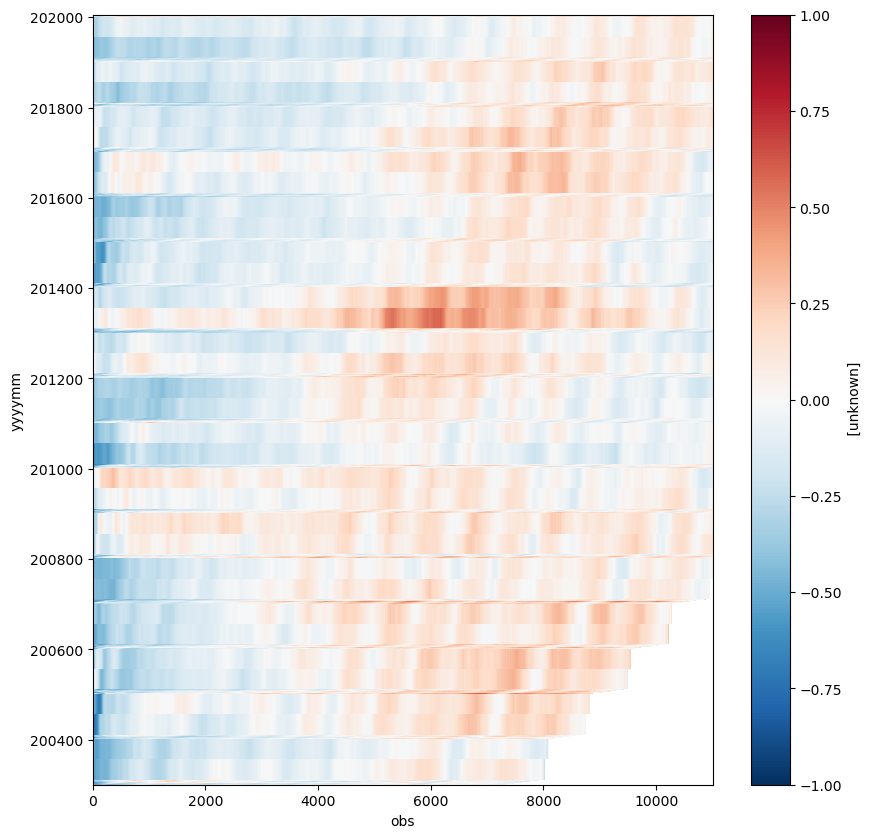

In [297]:
plt.figure(figsize=(10,10))
testing.isel(obs=slice(0,11_000)).plot(vmin=-1,vmax=1,cmap='RdBu_r')

#np.unique(p.yyyymm.isel(trajectory=sorted(avail_traj_extended)))

In [251]:
#p.start_time.dt.strftime('%Y%m').astype(int).isel(trajectory=sorted(avail_traj_extended)).groupby(yyyymm)

In [226]:
#p_assign = p.assign_coords(yyyymm=yyyymm)

#data_selected = p.isel(trajectory=sorted(avail_traj_extended)).assign_coords(yyyymm=('trajectory', yyyymm))

In [196]:
#p.start_time.dt.strftime('%Y%m').astype(int).isel(trajectory=sorted(avail_traj_extended)).groupby(yyyymm)

In [227]:
print(len(p.start_time.dt.strftime('%Y%m').astype(int).isel(trajectory=sorted(avail_traj_extended))))
print(len(p.isel(trajectory=sorted(avail_traj_extended))))

497743
10


In [200]:
p_selected = p.isel(trajectory=sorted(avail_traj_extended))



In [206]:
yyyymm = p_selected.start_time.dt.strftime('%Y%m').astype(int)


In [207]:
yyyymm

<xarray.DataArray 'strftime' (trajectory: 497743)>
array([200301, 200301, 200301, ..., 202005, 202005, 202005])
Coordinates:
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
  * start_time  (trajectory) datetime64[ns] 2003-01-01 ... 2020-05-31T00:00:01

In [205]:
p_selected.start_time

<xarray.DataArray 'start_time' (trajectory: 497743)>
array(['2003-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', ..., '2020-05-31T00:00:01.000000000',
       '2020-05-31T00:00:01.000000000', '2020-05-31T00:00:01.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
  * start_time  (trajectory) datetime64[ns] 2003-01-01 ... 2020-05-31T00:00:01
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

In [ ]:
reference =  p.z.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).groupby('start_time.month').mean().sel(year=slice(2003,2007)).mean('year') 
p_z_grouped = p.z.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).groupby('start_time.month')
(reference - p_z_grouped.mean()).T.plot()

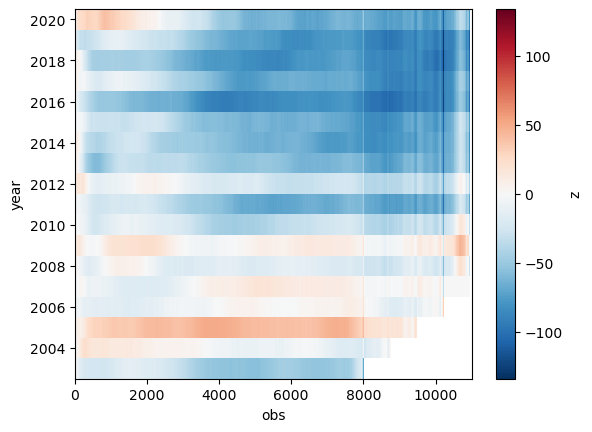

In [151]:
reference =  p.z.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).groupby('start_time.year').mean().sel(year=slice(2003,2007)).mean('year') 
p_z_grouped = p.z.isel(trajectory=sorted(avail_traj_extended), obs=slice(0,11_000)).groupby('start_time.year')
(reference - p_z_grouped.mean()).T.plot()

In [90]:
# reference =  p.temp.isel(trajectory=avail_traj, obs=slice(0,7500)).groupby('start_time.year').mean().sel(year=slice(2003,2007)).mean('year') 
# p_temp_grouped = p.temp.isel(trajectory=avail_traj, obs=slice(0,7500)).groupby('start_time.year')
# (reference - p_temp_grouped.mean()).T.plot()

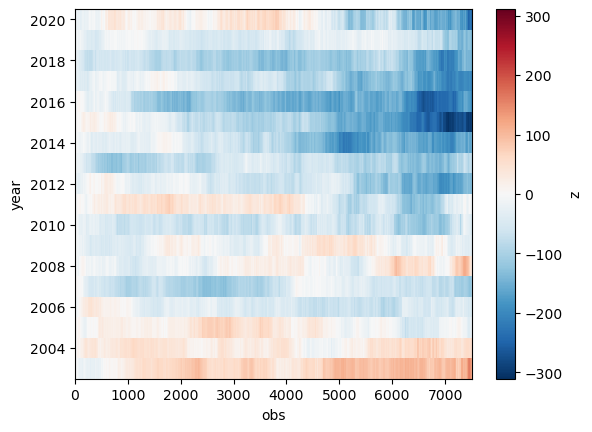

In [101]:
reference =  p.z.isel(trajectory=avail_traj, obs=slice(0,7500)).groupby('start_time.year').mean().sel(year=slice(2003,2007)).mean('year') 
p_z_grouped = p.z.isel(trajectory=avail_traj, obs=slice(0,7500)).groupby('start_time.year')
(reference - p_z_grouped.mean()).T.plot()

In [103]:
reference =  p.sigma0.isel(trajectory=avail_traj, obs=slice(0,7500)).groupby('start_time.year').mean().sel(year=slice(2003,2007)).mean('year') 
p_z_grouped = p.sigma0.isel(trajectory=avail_traj, obs=slice(0,7500)).groupby('start_time.year')
(reference - p_z_grouped.mean()).T.plot()

Task exception was never retrieved
future: <Task finished name='Task-265581' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-265578' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.clien

KeyboardInterrupt: 

In [35]:
np.arange(14,ds.trajectory.max() ,391)

array([     14,     405,     796, ..., 3517841, 3518232, 3518623])

In [34]:
p

<xarray.Dataset>
Dimensions:     (trajectory: 497743, obs: 20075)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 ... 20069 20070 20071 20072 20073 20074
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
  * start_time  (trajectory) datetime64[ns] 2003-01-01 ... 2020-05-31T00:00:01
Data variables:
    age         (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    lat         (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    lon         (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    salt        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    temp        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(782, 15330), meta=np.ndarray>
    uvel        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    vvel        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    z           (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    sigma0      (trajectory, obs) float64 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0